###1st Experiment: Do not consider bias in gender
1. Base model to extract features 
2. PCA on the image features (n_components = 200)
3. Base model binary classification on the features after PCA
4. Clustering on the features after PCA
5. Model of each cluster binary classification on the features after PCA
6. Random sample the same number of features after PCA and train model on it (Compare with the testing accuracy of its corresponding cluster to leave out the effect of sample size)
7. Compare the accuracy of the base model and the models of each clusters


## train-val 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pandas as pd 
df = pd.read_csv('gdrive/My Drive/cartact.csv')
len(df)

6392

In [4]:
df1 = df.loc[:, ['Patient Age','Patient Sex', 'Left-Fundus', 'Left-Diagnostic Keywords']]
df1.rename(columns = {'Left-Fundus':'Image', 'Left-Diagnostic Keywords':'Result'}, inplace = True)

dat_left = df1.loc[(df1['Result'] == 'cataract')|(df1['Result'] == 'normal fundus')]

df2 = df.loc[:, ['Patient Age','Patient Sex', 'Right-Fundus', 'Right-Diagnostic Keywords']]

df2.rename(columns = {'Right-Fundus':'Image', 'Right-Diagnostic Keywords':'Result'}, inplace = True)
dat_right = df2.loc[(df2['Result'] == 'cataract')|(df2['Result'] == 'normal fundus')]
dat_right.head(10)
data = dat_left.append(dat_right)
len(data)

6019

In [5]:

data_cfe = data[(data["Patient Sex"] == "Female") & (data["Result"] == "cataract")]
data_cm = data[(data["Patient Sex"] == "Male") & (data["Result"] == "cataract")]
# data_cfe = data_cfe.iloc[:220]
print(len(data_cfe), len(data_cm))
data_nfe = data[(data["Patient Sex"] == "Female") & (data["Result"] == "normal fundus")]
data_nfe = data_nfe.iloc[:298]
data_nm = data[(data["Patient Sex"] == "Male") & (data["Result"] == "normal fundus")]
data_nm = data_nm.iloc[:220]
print(len(data_nfe), len(data_nm))
frame_data = [data_cfe, data_cm, data_nfe, data_nm]
data = pd.concat(frame_data)
data = data.sample(frac = 1, random_state=42)
len(data)

298 220
298 220


1036

In [6]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data, 
                                   test_size = 0.20, 
                                   random_state = 2023,
                                   stratify = data[['Result']])

In [7]:
# have a look at the proportion of gender in training data
dat1 = train_df[(train_df["Patient Sex"] == "Female") & (train_df["Result"] == "cataract")]
dat2 = train_df[(train_df["Patient Sex"] == "Male") & (train_df["Result"] == "cataract")]

print(len(dat1), len(dat2))

dat3 = train_df[(train_df["Patient Sex"] == "Female") & (train_df["Result"] == "normal fundus")]
dat4 = train_df[(train_df["Patient Sex"] == "Male") & (train_df["Result"] == "normal fundus")]

print(len(dat3), len(dat4))

231 183
241 173


In [110]:
dat_cataract = train_df[(train_df["Result"] == "cataract")]
dat_normal = train_df[(train_df["Result"] == "normal fundus")]
frame_data = [dat_cataract, dat_normal]
train_df = pd.concat(frame_data)
print(len(train_df))

828


In [112]:
train_df = train_df.reset_index(drop=True)

In [ ]:
train_df.index.values

In [80]:
# select the images (cataract & normal) for training
train_cataract = train_df.loc[(train_df["Result"] == "cataract")]["Image"].values
train_normal = train_df.loc[(train_df["Result"] == "normal fundus")]["Image"].values

In [81]:
# select the images (cataract & normal) for testing
test_cataract = test_df.loc[(test_df["Result"] == "cataract")]["Image"].values
test_normal = test_df.loc[(test_df["Result"] == "normal fundus")]["Image"].values

In [10]:
import torch
import torch.nn.functional as F 
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
REQUIRES_PYTHON = '>=3.5.0'
VERSION = '0.1.0'
from torch import optim, nn
from torchvision import models, transforms

In [11]:
data_path='/content/drive/MyDrive/preprocessed_images'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("On which device we are on:{}".format(device))

from google.colab import drive
drive.mount('/content/drive')

On which device we are on:cpu
Mounted at /content/drive


In [82]:
# create training dataset, with x=images, y =label(1 is cataract, 0 is normal)
from pandas.core.common import random_state
import cv2
import glob
from PIL import Image
image_size=224
labels = []
dataset = []
random.seed(2023)
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(data_path,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([image,label])
    return dataset

dataset = create_dataset(train_cataract,1)

dataset = create_dataset(train_normal,0)
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3) #features
y = np.array([i[1] for i in dataset]) #labels
len(x)
len(y)

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

828

In [13]:
# create testing dataset, with x=images, y =label(1 is cataract, 0 is normal)
data_path='/content/drive/MyDrive/preprocessed_images'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("On which device we are on:{}".format(device))

from google.colab import drive
drive.mount('/content/drive')

from pandas.core.common import random_state
import cv2
import glob
image_size=224
labels = []
dataset = []
random.seed(1)
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(data_path,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

dataset = create_dataset(test_cataract,1)

dataset = create_dataset(test_normal,0)

x_testall = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3) #features
y_testall = np.array([i[1] for i in dataset]) #labels
len(x_testall)
len(y_testall)

On which device we are on:cpu
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

208

In [84]:
# Import base model efficientNetB0 for feature extraction
import numpy as np
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input
from keras.applications import EfficientNetB0
from keras.optimizers import Adam
from keras.utils import np_utils


In [139]:
# Fit the basemodel EfficientNet
from keras.applications.efficientnet import EfficientNetB0
efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

for layer in efficientnet.layers:
    layer.trainable = False

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
model.add(efficientnet)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("baseline_efficientnet.h5", monitor="val_loss", verbose=1, save_best_only=True, mode='min')
earlystop = EarlyStopping(monitor="val_loss", patience=5, verbose=1, mode='auto', restore_best_weights=True)

history = model.fit(x, y, batch_size=8, epochs=10, validation_data=(x_testall, y_testall), verbose=1, callbacks=[checkpoint, earlystop])

Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.4989 - accuracy: 0.9275
Epoch 1: val_loss improved from inf to 0.45825, saving model to baseline_efficientnet.h5
104/104 [==============================] - 72s 605ms/step - loss: 0.4989 - accuracy: 0.9275 - val_loss: 0.4582 - val_accuracy: 0.9375
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.4019 - accuracy: 0.9384
Epoch 2: val_loss did not improve from 0.45825
104/104 [==============================] - 58s 560ms/step - loss: 0.4019 - accuracy: 0.9384 - val_loss: 0.6743 - val_accuracy: 0.9615
Epoch 3/10
104/104 [==============================] - ETA: 0s - loss: 0.1760 - accuracy: 0.9758
Epoch 3: val_loss did not improve from 0.45825
104/104 [==============================] - 57s 545ms/step - loss: 0.1760 - accuracy: 0.9758 - val_loss: 0.5590 - val_accuracy: 0.9471
Epoch 4/10
104/104 [==============================] - ETA: 0s - loss: 0.0377 - accuracy: 0.9903
Epoch 4: val_loss improved from

In [140]:
testing_accuracy = history.history['val_accuracy'][-1]
print("Testing accuracy: {:.4f}".format(testing_accuracy))

Testing accuracy: 0.9663


In [141]:
import pandas as pd

features = efficientnet.predict(x)
#features_df = pd.DataFrame(features.reshape(-1, features.shape[-1]))
features_df = pd.DataFrame(features.reshape(features.shape[0], -1))
features_df.to_csv('features.csv', index=False)

26/26 [==============================] - 46s 2s/step


In [148]:
features_df = pd.DataFrame(features.reshape(features.shape[0], -1))

In [149]:
len(features_df)

828

In [ ]:
#from google.colab import files
#features_df.to_csv('features.csv', index=False)
#files.download('features.csv')

In [151]:
#features_df = pd.read_csv('features.csv')

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%config InlineBackend.figure_format='retina'
X_std = StandardScaler().fit_transform(features_df)
pca = PCA(n_components=0.85)
principalComponents = pca.fit_transform(X_std)
print(principalComponents.shape)

(828, 241)


In [ ]:
# highest silhouette score occurs when n_clusters = 4, elbow occurs when n_clusters = 4
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X = principalComponents
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    # Initialize KMeans model
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(X)

    # Calculate the silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

# Elbow Method
SSE = []
for cluster in range(1, 20):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(X)
    SSE.append(kmeans.inertia_)

# Convert the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')


In [155]:
kmeans = KMeans(n_clusters=4, random_state=0)
cluster_labels = kmeans.fit_predict(X)

In [156]:
cluster1_features = X[labels == 0]
cluster2_features = X[labels == 1]
cluster3_features = X[labels == 2]
cluster4_features = X[labels == 3]
print(cluster1_features.shape)
print(cluster2_features.shape)
print(cluster3_features.shape)
print(cluster4_features.shape)

(212, 241)
(276, 241)
(84, 241)
(256, 241)


In [157]:
X = pd.DataFrame(X)

cluster_map = pd.DataFrame()
cluster_map['data_index'] = X.index.values
cluster_map['cluster'] = labels
c0 = cluster_map[cluster_map.cluster == 0]
len(c0)
y0 = np.array([y[i] for i in c0.data_index])

In [163]:
c1 = cluster_map[cluster_map.cluster == 1]
y1 = np.array([y[i] for i in c1.data_index])
len(y1)

276

In [168]:
c2 = cluster_map[cluster_map.cluster == 2]
y2 = np.array([y[i] for i in c2.data_index])
len(y2)

84

In [171]:
c3 = cluster_map[cluster_map.cluster == 3]
y3 = np.array([y[i] for i in c3.data_index])
len(y3)

256

In [172]:
c0_df = train_df.loc[c0.data_index]
c1_df = train_df.loc[c1.data_index]
c2_df = train_df.loc[c2.data_index]
c3_df = train_df.loc[c3.data_index]

In [161]:
num_females = (c0_df['Patient Sex'] == 'Female').sum() 
print(num_females)
num_males = (c0_df['Patient Sex'] == 'Male').sum()
print(num_males)
num_cataract = (c0_df['Result'] == 'cataract').sum()
num_normal = (c0_df['Result'] == 'normal fundus').sum()
print(num_cataract)
print(num_normal)
num_over50 = (c0_df['Patient Age'] >= 50).sum()
print(num_over50)
num_less50 = (c0_df['Patient Age'] < 50).sum()
print(num_less50)

125
87
81
131
177
35


The distribution in the cluster1:
Female vs. Male = 125:87 \\
Cataract vs. Normal = 81:131 \\
Patient Age >= 50 vs. Patient Age < 50 = 177:35

In [167]:
num_females = (c1_df['Patient Sex'] == 'Female').sum()
print(num_females)
num_males = (c1_df['Patient Sex'] == 'Male').sum()
print(num_males)
num_cataract = (c1_df['Result'] == 'cataract').sum()
num_normal = (c1_df['Result'] == 'normal fundus').sum()
print(num_cataract)
print(num_normal)
num_over50 = (c1_df['Patient Age'] >= 50).sum()
print(num_over50)
num_less50 = (c1_df['Patient Age'] < 50).sum()
print(num_less50)

160
116
261
15
256
20


The distribution in the cluster2:
Female vs. Male = 160:116 \\
Cataract vs. Normal = 261:15 \\
Patient Age >= 50 vs. Patient Age < 50 = 256:20

In [170]:
num_females = (c2_df['Patient Sex'] == 'Female').sum()
print(num_females)
num_males = (c2_df['Patient Sex'] == 'Male').sum()
print(num_males)
num_cataract = (c2_df['Result'] == 'cataract').sum()
num_normal = (c2_df['Result'] == 'normal fundus').sum()
print(num_cataract)
print(num_normal)
num_over50 = (c2_df['Patient Age'] >= 50).sum()
print(num_over50)
num_less50 = (c2_df['Patient Age'] < 50).sum()
print(num_less50)

45
39
61
23
74
10


The distribution in the cluster3:
Female vs. Male = 45:39 \\
Cataract vs. Normal = 61:23 \\
Patient Age >= 50 vs. Patient Age < 50 = 74:10

In [173]:
num_females = (c3_df['Patient Sex'] == 'Female').sum()
print(num_females)
num_males = (c3_df['Patient Sex'] == 'Male').sum()
print(num_males)
num_cataract = (c3_df['Result'] == 'cataract').sum()
num_normal = (c3_df['Result'] == 'normal fundus').sum()
print(num_cataract)
print(num_normal)
num_over50 = (c3_df['Patient Age'] >= 50).sum()
print(num_over50)
num_less50 = (c3_df['Patient Age'] < 50).sum()
print(num_less50)

142
114
11
245
216
40


The distribution in cluster4:
Female vs. Male = 142:114 \\
Cataract vs. Normal = 11:245 \\
Patient Age >= 50 vs. Patient Age < 50 = 216:40

In [174]:
x0 = np.array([x[i] for i in c0.data_index])
y0 = np.array([y[i] for i in c0.data_index])
x0.shape

(212, 224, 224, 3)

In [175]:
x1 = np.array([x[i] for i in c1.data_index])
y1 = np.array([y[i] for i in c1.data_index])
x1.shape

(276, 224, 224, 3)

In [176]:
x2 = np.array([x[i] for i in c2.data_index])
y2 = np.array([y[i] for i in c2.data_index])
x2.shape

(84, 224, 224, 3)

In [177]:
x3 = np.array([x[i] for i in c3.data_index])
y3 = np.array([y[i] for i in c3.data_index])
x3.shape

(256, 224, 224, 3)

In [178]:
from keras.applications.efficientnet import EfficientNetB0
efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

for layer in efficientnet.layers:
    layer.trainable = False

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
model.add(efficientnet)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("c0_efficientnet.h5", monitor="val_loss", verbose=1, save_best_only=True, mode='min')
earlystop = EarlyStopping(monitor="val_loss", patience=5, verbose=1, mode='auto', restore_best_weights=True)

history = model.fit(x0, y0, batch_size=8, epochs=10, validation_data=(x_testall, y_testall), verbose=1, callbacks=[checkpoint, earlystop])

Epoch 1/10
27/27 [==============================] - ETA: 0s - loss: 1.4722 - accuracy: 0.8160
Epoch 1: val_loss improved from inf to 1.51914, saving model to baseline_efficientnet.h5
27/27 [==============================] - 35s 941ms/step - loss: 1.4722 - accuracy: 0.8160 - val_loss: 1.5191 - val_accuracy: 0.8942
Epoch 2/10
27/27 [==============================] - ETA: 0s - loss: 0.7861 - accuracy: 0.9245
Epoch 2: val_loss improved from 1.51914 to 0.76412, saving model to baseline_efficientnet.h5
27/27 [==============================] - 23s 859ms/step - loss: 0.7861 - accuracy: 0.9245 - val_loss: 0.7641 - val_accuracy: 0.9423
Epoch 3/10
27/27 [==============================] - ETA: 0s - loss: 0.2342 - accuracy: 0.9575
Epoch 3: val_loss improved from 0.76412 to 0.53012, saving model to baseline_efficientnet.h5
27/27 [==============================] - 23s 882ms/step - loss: 0.2342 - accuracy: 0.9575 - val_loss: 0.5301 - val_accuracy: 0.9519
Epoch 4/10
27/27 [=============================

In [179]:
test_loss, test_acc = model.evaluate(x_testall, y_testall)

7/7 [==============================] - 13s 2s/step - loss: 0.7197 - accuracy: 0.9615


Testing accuracy of Cluster1: 0.9615

In [180]:
from keras.applications.efficientnet import EfficientNetB0
efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

for layer in efficientnet.layers:
    layer.trainable = False

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
model.add(efficientnet)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("c1_efficientnet.h5", monitor="val_loss", verbose=1, save_best_only=True, mode='min')
earlystop = EarlyStopping(monitor="val_loss", patience=5, verbose=1, mode='auto', restore_best_weights=True)

history = model.fit(x1, y1, batch_size=8, epochs=10, validation_data=(x_testall, y_testall), verbose=1, callbacks=[checkpoint, earlystop])

Epoch 1/10
35/35 [==============================] - ETA: 0s - loss: 1.0402 - accuracy: 0.9022
Epoch 1: val_loss improved from inf to 0.73691, saving model to c1_efficientnet.h5
35/35 [==============================] - 37s 827ms/step - loss: 1.0402 - accuracy: 0.9022 - val_loss: 0.7369 - val_accuracy: 0.9135
Epoch 2/10
35/35 [==============================] - ETA: 0s - loss: 0.1920 - accuracy: 0.9783
Epoch 2: val_loss did not improve from 0.73691
35/35 [==============================] - 26s 751ms/step - loss: 0.1920 - accuracy: 0.9783 - val_loss: 0.8209 - val_accuracy: 0.9231
Epoch 3/10
35/35 [==============================] - ETA: 0s - loss: 0.1224 - accuracy: 0.9710
Epoch 3: val_loss did not improve from 0.73691
35/35 [==============================] - 29s 829ms/step - loss: 0.1224 - accuracy: 0.9710 - val_loss: 1.7341 - val_accuracy: 0.6875
Epoch 4/10
35/35 [==============================] - ETA: 0s - loss: 0.0246 - accuracy: 0.9928
Epoch 4: val_loss did not improve from 0.73691
35/3

In [181]:
test_loss, test_acc = model.evaluate(x_testall, y_testall)

7/7 [==============================] - 13s 2s/step - loss: 0.7369 - accuracy: 0.9135


Testing accuracy of Cluster2 is 0.9135

In [182]:
from keras.applications.efficientnet import EfficientNetB0
efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

for layer in efficientnet.layers:
    layer.trainable = False

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
model.add(efficientnet)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("c2_efficientnet.h5", monitor="val_loss", verbose=1, save_best_only=True, mode='min')
earlystop = EarlyStopping(monitor="val_loss", patience=5, verbose=1, mode='auto', restore_best_weights=True)

history = model.fit(x2, y2, batch_size=8, epochs=10, validation_data=(x_testall, y_testall), verbose=1, callbacks=[checkpoint, earlystop])

Epoch 1/10
11/11 [==============================] - ETA: 0s - loss: 0.4838 - accuracy: 0.8214
Epoch 1: val_loss improved from inf to 0.64674, saving model to c2_efficientnet.h5
11/11 [==============================] - 25s 2s/step - loss: 0.4838 - accuracy: 0.8214 - val_loss: 0.6467 - val_accuracy: 0.9375
Epoch 2/10
11/11 [==============================] - ETA: 0s - loss: 0.0339 - accuracy: 0.9881
Epoch 2: val_loss did not improve from 0.64674
11/11 [==============================] - 16s 2s/step - loss: 0.0339 - accuracy: 0.9881 - val_loss: 0.9707 - val_accuracy: 0.9327
Epoch 3/10
11/11 [==============================] - ETA: 0s - loss: 3.4963e-04 - accuracy: 1.0000
Epoch 3: val_loss did not improve from 0.64674
11/11 [==============================] - 16s 2s/step - loss: 3.4963e-04 - accuracy: 1.0000 - val_loss: 1.2143 - val_accuracy: 0.9183
Epoch 4/10
11/11 [==============================] - ETA: 0s - loss: 0.0091 - accuracy: 1.0000
Epoch 4: val_loss did not improve from 0.64674
11/11

In [183]:
test_loss, test_acc = model.evaluate(x_testall, y_testall)

7/7 [==============================] - 13s 2s/step - loss: 0.6467 - accuracy: 0.9375


Testing accuracy of Cluster 3 is 0.9375

In [184]:
from keras.applications.efficientnet import EfficientNetB0
efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

for layer in efficientnet.layers:
    layer.trainable = False

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
model.add(efficientnet)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("c3_efficientnet.h5", monitor="val_loss", verbose=1, save_best_only=True, mode='min')
earlystop = EarlyStopping(monitor="val_loss", patience=5, verbose=1, mode='auto', restore_best_weights=True)

history = model.fit(x3, y3, batch_size=8, epochs=10, validation_data=(x_testall, y_testall), verbose=1, callbacks=[checkpoint, earlystop])

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.7483 - accuracy: 0.9297
Epoch 1: val_loss improved from inf to 2.99249, saving model to c3_efficientnet.h5
32/32 [==============================] - 33s 854ms/step - loss: 0.7483 - accuracy: 0.9297 - val_loss: 2.9925 - val_accuracy: 0.5192
Epoch 2/10
32/32 [==============================] - ETA: 0s - loss: 0.2948 - accuracy: 0.9688
Epoch 2: val_loss improved from 2.99249 to 0.98996, saving model to c3_efficientnet.h5
32/32 [==============================] - 26s 817ms/step - loss: 0.2948 - accuracy: 0.9688 - val_loss: 0.9900 - val_accuracy: 0.8365
Epoch 3/10
32/32 [==============================] - ETA: 0s - loss: 0.2384 - accuracy: 0.9727
Epoch 3: val_loss improved from 0.98996 to 0.78900, saving model to c3_efficientnet.h5
32/32 [==============================] - 26s 810ms/step - loss: 0.2384 - accuracy: 0.9727 - val_loss: 0.7890 - val_accuracy: 0.8654
Epoch 4/10
32/32 [==============================] - ETA: 0s - los

In [185]:
test_loss, test_acc = model.evaluate(x_testall, y_testall)

7/7 [==============================] - 12s 1s/step - loss: 0.7890 - accuracy: 0.8654


Testing accuracy of Cluster 4 is 0.8654.

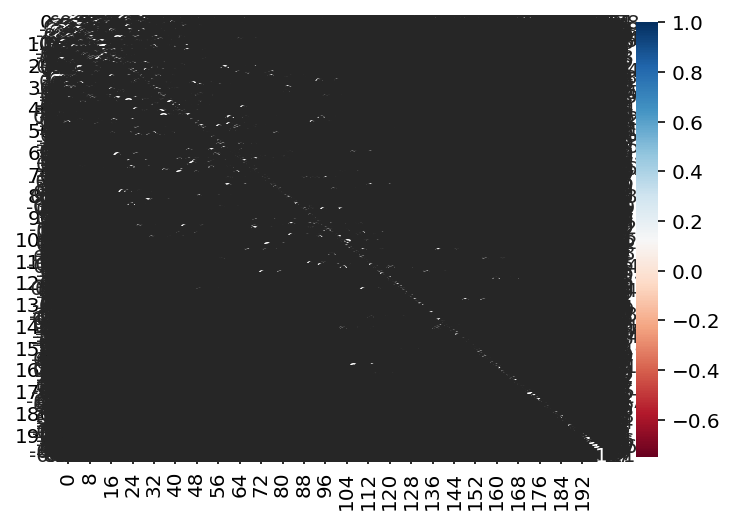

In [127]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

c0_features = pd.DataFrame(cluster1_features)
corr = c0_features.corr()

# Plot the heatmap
sns.heatmap(corr, annot=True, cmap='RdBu')

# Show the plot
plt.show()

In [136]:
print(c0_df.columns)

Index(['Patient Age', 'Patient Sex', 'Image', 'Result'], dtype='object')


In [26]:
c1 = cluster_map[cluster_map.cluster == 1]
len(c1)
y1 = np.array([y[i] for i in c1.data_index])
print(len(y1))

275


In [27]:
c2 = cluster_map[cluster_map.cluster == 2]
len(c2)
y2 = np.array([y[i] for i in c2.data_index])
print(len(y2))

256


In [28]:
c3 = cluster_map[cluster_map.cluster == 3]
len(c3)
y3 = np.array([y[i] for i in c3.data_index])
print(len(y3))

93


In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout

model = Sequential()
model.add(Flatten(input_shape=principalComponents.shape[1:]))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(cluster1_features, y0, epochs=100, batch_size=10)

In [30]:
test_loss, test_accuracy = model.evaluate(principalComponents_test, y_testall, batch_size = 10)
print('Test accuracy:', test_accuracy)

21/21 [==============================] - 0s 2ms/step - loss: 5.2718 - accuracy: 0.7019
Test accuracy: 0.7019230723381042


In [31]:
# Random sample n=203 from the training data (to compare with 1st cluster and leave out the effect of sample size)
import random
principalComponents_list = list(principalComponents)
sample1 = random.sample(principalComponents_list, 203)

In [32]:
sample1= np.array(sample1)
sample1.shape

(203, 200)

In [33]:
indexes = []
for s in sample1:
    index = np.where(principalComponents == s)[0][0]
    indexes.append(index)
len(indexes)

203

In [34]:
y0_random = [y[index] for index in indexes]
y0_random = np.array(y0_random, dtype=np.int64)

In [35]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout

model = Sequential()
model.add(Flatten(input_shape=principalComponents.shape[1:]))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(sample1, y0_random, epochs=100, batch_size=10)

Epoch 1/100
21/21 [==============================] - 1s 2ms/step - loss: 8.3175 - accuracy: 0.5369
Epoch 2/100
21/21 [==============================] - 0s 2ms/step - loss: 4.8895 - accuracy: 0.6995
Epoch 3/100
21/21 [==============================] - 0s 2ms/step - loss: 3.1046 - accuracy: 0.8030
Epoch 4/100
21/21 [==============================] - 0s 2ms/step - loss: 2.2596 - accuracy: 0.8473
Epoch 5/100
21/21 [==============================] - 0s 3ms/step - loss: 1.6971 - accuracy: 0.8621
Epoch 6/100
21/21 [==============================] - 0s 2ms/step - loss: 1.0574 - accuracy: 0.8818
Epoch 7/100
21/21 [==============================] - 0s 2ms/step - loss: 0.9874 - accuracy: 0.8916
Epoch 8/100
21/21 [==============================] - 0s 2ms/step - loss: 0.6714 - accuracy: 0.9113
Epoch 9/100
21/21 [==============================] - 0s 2ms/step - loss: 1.0573 - accuracy: 0.9261
Epoch 10/100
21/21 [==============================] - 0s 2ms/step - loss: 0.4437 - accuracy: 0.9507
Epoch 11/

In [36]:
test_loss, test_accuracy = model.evaluate(principalComponents_test, y_testall, batch_size = 10)
print('Test accuracy:', test_accuracy)

21/21 [==============================] - 0s 1ms/step - loss: 4.5112 - accuracy: 0.7981
Test accuracy: 0.7980769276618958


In [37]:
# Model for 2nd Cluster
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout

model = Sequential()
model.add(Flatten(input_shape=principalComponents.shape[1:]))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(cluster2_features, y1, epochs=100, batch_size=10)

Epoch 1/100
28/28 [==============================] - 1s 2ms/step - loss: 2.8976 - accuracy: 0.8000
Epoch 2/100
28/28 [==============================] - 0s 2ms/step - loss: 0.8991 - accuracy: 0.9127
Epoch 3/100
28/28 [==============================] - 0s 2ms/step - loss: 0.5238 - accuracy: 0.9345
Epoch 4/100
28/28 [==============================] - 0s 3ms/step - loss: 0.3729 - accuracy: 0.9527
Epoch 5/100
28/28 [==============================] - 0s 2ms/step - loss: 0.6023 - accuracy: 0.9382
Epoch 6/100
28/28 [==============================] - 0s 3ms/step - loss: 0.1595 - accuracy: 0.9782
Epoch 7/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1504 - accuracy: 0.9782
Epoch 8/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1392 - accuracy: 0.9745
Epoch 9/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0700 - accuracy: 0.9855
Epoch 10/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0692 - accuracy: 0.9709
Epoch 11/

In [38]:
test_loss, test_accuracy = model.evaluate(principalComponents_test, y_testall, batch_size = 10)
print('Test accuracy:', test_accuracy)

21/21 [==============================] - 0s 1ms/step - loss: 9.0534 - accuracy: 0.6683
Test accuracy: 0.6682692170143127


In [39]:
# Random sample n=275 from the training data (to compare with 2nd cluster and leave out the effect of sample size)
import random
principalComponents_list = list(principalComponents)
sample2 = random.sample(principalComponents_list, 275)
sample2= np.array(sample2)
sample2.shape
indexes2 = []
for s in sample2:
    index = np.where(principalComponents == s)[0][0]
    indexes2.append(index)
len(indexes2)

y1_random = [y[index] for index in indexes2]
y1_random = np.array(y1_random, dtype=np.int64)

In [40]:
# Model for the random sample (to be compared with 2nd cluster)
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout

model = Sequential()
model.add(Flatten(input_shape=principalComponents.shape[1:]))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(sample2, y1_random, epochs=100, batch_size=10)

Epoch 1/100
28/28 [==============================] - 1s 3ms/step - loss: 6.6828 - accuracy: 0.5600
Epoch 2/100
28/28 [==============================] - 0s 2ms/step - loss: 2.5208 - accuracy: 0.7636
Epoch 3/100
28/28 [==============================] - 0s 3ms/step - loss: 2.2957 - accuracy: 0.8436
Epoch 4/100
28/28 [==============================] - 0s 2ms/step - loss: 1.4546 - accuracy: 0.8945
Epoch 5/100
28/28 [==============================] - 0s 3ms/step - loss: 1.2627 - accuracy: 0.8909
Epoch 6/100
28/28 [==============================] - 0s 2ms/step - loss: 0.6178 - accuracy: 0.9273
Epoch 7/100
28/28 [==============================] - 0s 2ms/step - loss: 0.6743 - accuracy: 0.9345
Epoch 8/100
28/28 [==============================] - 0s 3ms/step - loss: 0.7680 - accuracy: 0.9491
Epoch 9/100
28/28 [==============================] - 0s 3ms/step - loss: 0.8185 - accuracy: 0.9418
Epoch 10/100
28/28 [==============================] - 0s 3ms/step - loss: 0.4788 - accuracy: 0.9382
Epoch 11/

In [41]:
test_loss, test_accuracy = model.evaluate(principalComponents_test, y_testall, batch_size = 10)
print('Test accuracy:', test_accuracy)

21/21 [==============================] - 0s 2ms/step - loss: 4.5587 - accuracy: 0.8125
Test accuracy: 0.8125


In [42]:
# Model for 3rd Cluster
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout

model = Sequential()
model.add(Flatten(input_shape=principalComponents.shape[1:]))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(cluster3_features, y2, epochs=100, batch_size=10)

Epoch 1/100
26/26 [==============================] - 1s 2ms/step - loss: 2.8319 - accuracy: 0.8086
Epoch 2/100
26/26 [==============================] - 0s 2ms/step - loss: 2.2474 - accuracy: 0.8711
Epoch 3/100
26/26 [==============================] - 0s 2ms/step - loss: 0.9346 - accuracy: 0.9219
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 0.2293 - accuracy: 0.9844
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 0.4529 - accuracy: 0.9492
Epoch 6/100
26/26 [==============================] - 0s 2ms/step - loss: 0.1091 - accuracy: 0.9766
Epoch 7/100
26/26 [==============================] - 0s 2ms/step - loss: 0.1626 - accuracy: 0.9727
Epoch 8/100
26/26 [==============================] - 0s 2ms/step - loss: 0.1146 - accuracy: 0.9844
Epoch 9/100
26/26 [==============================] - 0s 2ms/step - loss: 0.1455 - accuracy: 0.9492
Epoch 10/100
26/26 [==============================] - 0s 2ms/step - loss: 0.1421 - accuracy: 0.9766
Epoch 11/

In [43]:
test_loss, test_accuracy = model.evaluate(principalComponents_test, y_testall, batch_size = 10)
print('Test accuracy:', test_accuracy)

21/21 [==============================] - 0s 2ms/step - loss: 19.1916 - accuracy: 0.5144
Test accuracy: 0.5144230723381042


In [44]:
# Random sample n=257 from the training data (to compare with 3rd cluster and leave out the effect of sample size)
import random
principalComponents_list = list(principalComponents)
sample3 = random.sample(principalComponents_list, 257)
sample3= np.array(sample3)
sample3.shape
indexes3 = []
for s in sample3:
    index = np.where(principalComponents == s)[0][0]
    indexes3.append(index)
len(indexes3)

y2_random = [y[index] for index in indexes3]
y2_random = np.array(y2_random, dtype=np.int64)
y2_random.shape

(257,)

In [45]:
# Model for the random sample (to be compared with 3rd cluster)
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout

model = Sequential()
model.add(Flatten(input_shape=principalComponents.shape[1:]))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(sample3, y2_random, epochs=100, batch_size=10)

Epoch 1/100
26/26 [==============================] - 1s 2ms/step - loss: 8.1016 - accuracy: 0.5292
Epoch 2/100
26/26 [==============================] - 0s 2ms/step - loss: 4.9994 - accuracy: 0.5992
Epoch 3/100
26/26 [==============================] - 0s 2ms/step - loss: 2.0399 - accuracy: 0.8171
Epoch 4/100
26/26 [==============================] - 0s 2ms/step - loss: 1.8023 - accuracy: 0.8132
Epoch 5/100
26/26 [==============================] - 0s 2ms/step - loss: 1.5725 - accuracy: 0.8755
Epoch 6/100
26/26 [==============================] - 0s 2ms/step - loss: 0.7252 - accuracy: 0.9027
Epoch 7/100
26/26 [==============================] - 0s 2ms/step - loss: 1.0824 - accuracy: 0.8988
Epoch 8/100
26/26 [==============================] - 0s 2ms/step - loss: 0.7784 - accuracy: 0.9144
Epoch 9/100
26/26 [==============================] - 0s 2ms/step - loss: 0.6338 - accuracy: 0.9183
Epoch 10/100
26/26 [==============================] - 0s 2ms/step - loss: 0.2017 - accuracy: 0.9572
Epoch 11/

In [46]:
test_loss, test_accuracy = model.evaluate(principalComponents_test, y_testall, batch_size = 10)
print('Test accuracy:', test_accuracy)

21/21 [==============================] - 0s 2ms/step - loss: 3.1223 - accuracy: 0.8221
Test accuracy: 0.8221153616905212


In [47]:
# Model for 4th Cluster
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout

model = Sequential()
model.add(Flatten(input_shape=principalComponents.shape[1:]))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(cluster4_features, y3, epochs=100, batch_size=10)

Epoch 1/100
10/10 [==============================] - 1s 2ms/step - loss: 9.2518 - accuracy: 0.6667
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 9.3737 - accuracy: 0.6237
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 8.1396 - accuracy: 0.7097
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 4.7170 - accuracy: 0.8495
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 2.2876 - accuracy: 0.8817
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 4.2390 - accuracy: 0.8387
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 3.4208 - accuracy: 0.8280
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 1.4795 - accuracy: 0.8817
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 2.2350 - accuracy: 0.8602
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 2.2720 - accuracy: 0.8925
Epoch 11/

In [48]:
test_loss, test_accuracy = model.evaluate(principalComponents_test, y_testall, batch_size = 10)
print('Test accuracy:', test_accuracy)

21/21 [==============================] - 0s 2ms/step - loss: 9.9946 - accuracy: 0.5288
Test accuracy: 0.5288461446762085


In [49]:
# Random sample n=93 from the training data (to compare with 4th cluster and leave out the effect of sample size)
import random
principalComponents_list = list(principalComponents)
sample4 = random.sample(principalComponents_list, 93)
sample4= np.array(sample4)
sample4.shape
indexes4 = []
for s in sample4:
    index = np.where(principalComponents == s)[0][0]
    indexes4.append(index)
len(indexes4)

y3_random = [y[index] for index in indexes4]
y3_random = np.array(y3_random, dtype=np.int64)
y3_random.shape

(93,)

In [50]:
# Model for the random sample (to be compared with 4th cluster)
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout

model = Sequential()
model.add(Flatten(input_shape=principalComponents.shape[1:]))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(sample4, y3_random, epochs=100, batch_size=10)

Epoch 1/100
10/10 [==============================] - 1s 3ms/step - loss: 10.2575 - accuracy: 0.5484
Epoch 2/100
10/10 [==============================] - 0s 3ms/step - loss: 6.4014 - accuracy: 0.6022
Epoch 3/100
10/10 [==============================] - 0s 3ms/step - loss: 4.9566 - accuracy: 0.7204
Epoch 4/100
10/10 [==============================] - 0s 3ms/step - loss: 3.6741 - accuracy: 0.7634
Epoch 5/100
10/10 [==============================] - 0s 3ms/step - loss: 2.6019 - accuracy: 0.8387
Epoch 6/100
10/10 [==============================] - 0s 3ms/step - loss: 2.1208 - accuracy: 0.8280
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 1.6691 - accuracy: 0.8495
Epoch 8/100
10/10 [==============================] - 0s 3ms/step - loss: 0.8037 - accuracy: 0.9032
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 1.2767 - accuracy: 0.8925
Epoch 10/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.9247
Epoch 11

In [51]:
test_loss, test_accuracy = model.evaluate(principalComponents_test, y_testall, batch_size = 10)
print('Test accuracy:', test_accuracy)

21/21 [==============================] - 0s 1ms/step - loss: 3.5558 - accuracy: 0.7933
Test accuracy: 0.7932692170143127
